In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Add Bayesian-and-novelty directory to the PYTHONPATH
import sys
import os
sys.path.append(os.path.realpath('../../..'))

# Autoreload changes in utils, etc.
%load_ext autoreload
%autoreload 2

from novelty.utils.metrics import plot_roc, plot_prc
from novelty.utils.metrics import get_summary_statistics
from novelty.utils.metrics import html_summary_table
from novelty.utils.metrics import barcode_plot

In [2]:
# Training settings
BATCH_SIZE = 128
EPOCHS = 100
LR = 0.01
MOMENTUM = 0.5
NO_CUDA = False
SEED = 1

# MNIST mean and stdevs of training data by channel
CHANNEL_MEANS = (33.791240975260735/255,)
CHANNEL_STDS = (79.17246803641319/255,)

# Plot ROC and PR curves
PLOT_CHARTS = True

# ODIN parameters
TEMP = 1000.
NOISE_MAGNITUDE = 0.0012

## Create network architecture

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        # return F.log_softmax(x, dim=1)
        return x

## Training and Testing functions

In [4]:
from novelty.utils import Progbar


def train(model, device, train_loader, optimizer, epoch):
    progbar = Progbar(target=len(train_loader.dataset))

    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = F.log_softmax(model(data), dim=1)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        progbar.add(len(data), [("loss", loss.item())])

In [5]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = F.log_softmax(model(data), dim=1)
            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

## Initialize model and load MNIST

In [6]:
from novelty.utils import DATA_DIR

torch.manual_seed(SEED)

use_cuda = not NO_CUDA and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Dataset transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CHANNEL_MEANS, CHANNEL_STDS)
])

# Load training and test sets
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(DATA_DIR, train=True, transform=transform, download=True),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(DATA_DIR, train=False, transform=transform, download=True),
    batch_size=BATCH_SIZE, shuffle=False, **kwargs)

# Create model instance
model = Net().to(device)

# Initialize optimizer
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)

## Optimization loop

In [7]:
MODEL_PATH = './cnn_net_new.pth'

if os.path.exists(MODEL_PATH):
    # load previously trained model:
    model.load_state_dict(torch.load(MODEL_PATH))

else:
    # Training loop
    for epoch in range(1, EPOCHS + 1):
        print("Epoch:", epoch)
        train(model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)

    # save the model 
    torch.save(model.state_dict(), MODEL_PATH)

Epoch: 1
60000/60000 [==============================] - 3s 45us/step - loss: 1.2732
Test set: Average loss: 0.3329, Accuracy: 9071/10000 (91%)

Epoch: 2
60000/60000 [==============================] - 2s 36us/step - loss: 0.5286
Test set: Average loss: 0.1983, Accuracy: 9420/10000 (94%)

Epoch: 3
60000/60000 [==============================] - 2s 36us/step - loss: 0.4023
Test set: Average loss: 0.1451, Accuracy: 9560/10000 (96%)

Epoch: 4
60000/60000 [==============================] - 2s 38us/step - loss: 0.3395
Test set: Average loss: 0.1203, Accuracy: 9626/10000 (96%)

Epoch: 5
60000/60000 [==============================] - 2s 37us/step - loss: 0.2984
Test set: Average loss: 0.1042, Accuracy: 9670/10000 (97%)

Epoch: 6
60000/60000 [==============================] - 2s 38us/step - loss: 0.2697
Test set: Average loss: 0.0957, Accuracy: 9700/10000 (97%)

Epoch: 7
60000/60000 [==============================] - 2s 37us/step - loss: 0.2512
Test set: Average loss: 0.0854, Accuracy: 9731/10000

Test set: Average loss: 0.0338, Accuracy: 9890/10000 (99%)

Epoch: 58
60000/60000 [==============================] - 2s 36us/step - loss: 0.1078
Test set: Average loss: 0.0318, Accuracy: 9907/10000 (99%)

Epoch: 59
60000/60000 [==============================] - 2s 36us/step - loss: 0.1080
Test set: Average loss: 0.0334, Accuracy: 9898/10000 (99%)

Epoch: 60
60000/60000 [==============================] - 2s 37us/step - loss: 0.1073
Test set: Average loss: 0.0334, Accuracy: 9898/10000 (99%)

Epoch: 61
60000/60000 [==============================] - 2s 37us/step - loss: 0.1061
Test set: Average loss: 0.0332, Accuracy: 9899/10000 (99%)

Epoch: 62
60000/60000 [==============================] - 2s 37us/step - loss: 0.1073
Test set: Average loss: 0.0326, Accuracy: 9900/10000 (99%)

Epoch: 63
60000/60000 [==============================] - 2s 36us/step - loss: 0.1055
Test set: Average loss: 0.0319, Accuracy: 9901/10000 (99%)

Epoch: 64
60000/60000 [==============================] - 2s 38us/step 

## ODIN prediction functions

In [8]:
from torch.autograd import Variable


def predict(model, data, device):
    model.eval()
    data = data.to(device)
    outputs = model(data)
    outputs = outputs - outputs.max(1)[0].unsqueeze(1)  # For stability
    return F.softmax(outputs, dim=1)


def predict_temp(model, data, device, temp=1000.):
    model.eval()
    data = data.to(device)
    outputs = model(data)
    outputs /= temp
    outputs = outputs - outputs.max(1)[0].unsqueeze(1)  # For stability
    return F.softmax(outputs, dim=1)


def predict_novelty(model, data, device, temp=1000., noiseMagnitude=0.0012):
    model.eval()

    # Create a variable so we can get the gradients on the input
    inputs = Variable(data.to(device), requires_grad=True)

    # Get the predicted labels
    outputs = model(inputs)
    outputs = outputs / temp
    outputs = F.log_softmax(outputs, dim=1)

    # Calculate the perturbation to add to the input
    maxIndexTemp = torch.argmax(outputs, dim=1)
    labels = Variable(maxIndexTemp).to(device)
    loss = F.nll_loss(outputs, labels)
    loss.backward()

    # Normalizing the gradient to binary in {0, 1}
    gradient = torch.ge(inputs.grad.data, 0)
    gradient = (gradient.float() - 0.5) * 2

    # Normalize the gradient to the same space of image
    for channel, (mean, std) in enumerate(zip(CHANNEL_MEANS, CHANNEL_STDS)):
        gradient[0][channel] = (gradient[0][channel] - mean) / std

    # Add small perturbations to image
    # TODO, this is from the released code, but disagrees with paper I think
    tempInputs = torch.add(inputs.data, -noiseMagnitude, gradient)

    # Get new outputs after perturbations
    outputs = model(Variable(tempInputs))
    outputs = outputs / temp
    outputs = outputs - outputs.max(1)[0].unsqueeze(1)  # For stability
    outputs = F.softmax(outputs, dim=1)

    return outputs

# Run Test Suite

Running MNIST test suite
Loading inlier dataset
Testing Fashion MNIST
20000/20000 [==============================] - 28s 1ms/step


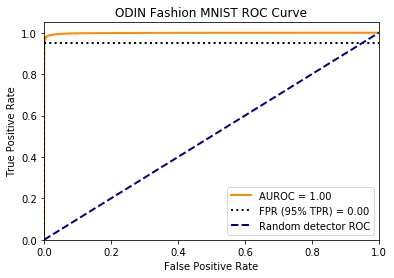

Testing EMNIST Letters
30800/30800 [==============================] - 44s 1ms/step


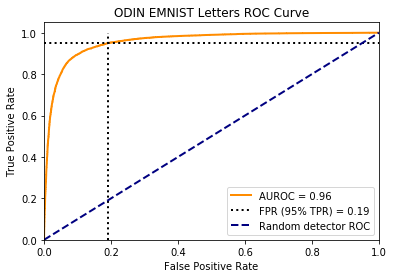

Testing NotMNIST
28724/28724 [==============================] - 44s 2ms/step


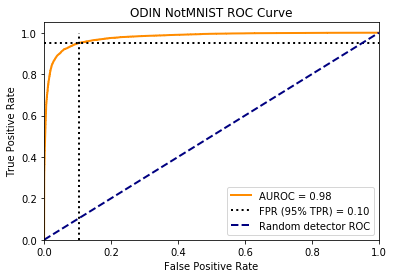

Testing MNIST (Rotated 90deg)
20000/20000 [==============================] - 29s 1ms/step


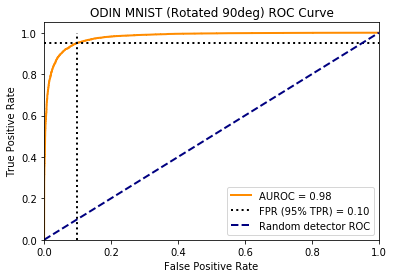

Testing Gaussian Noise
20000/20000 [==============================] - 28s 1ms/step


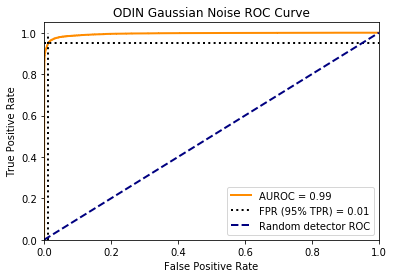

Testing Uniform Noise
20000/20000 [==============================] - 28s 1ms/step


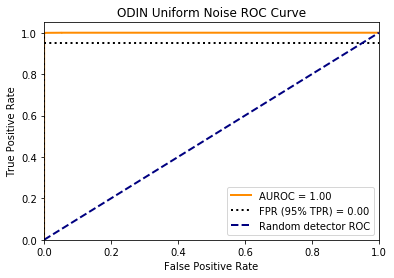

In [11]:
from novelty.test_mnist import test_mnist
from PIL import Image

transform = transforms.Compose([
    transforms.Resize(32), # Resize to work with WRN
    transforms.ToTensor(),
    transforms.Normalize(CHANNEL_MEANS, CHANNEL_STDS),
    transforms.Lambda(lambda x: x.expand(3, -1, -1)) # Expand to 3 channels to work with WRN model
])

# Define a prediction function
def pred(np_data):
    np_data = np.moveaxis(np_data, 1, 3)
    
    scores = []
    for d in np_data:    
        d = transform(d)
        d = d.unsqueeze(0)

        softmax_out = predict_novelty(
            model, d, device, temp=TEMP, 
            noiseMagnitude=NOISE_MAGNITUDE)
        
        max_val, label = torch.max(softmax_out, dim=1)
        scores.append(max_val.cpu().detach().numpy())
    
    return scores

# Run the test suite function. (Takes some time)
stats = test_mnist(
    pred, 
    batch_size=BATCH_SIZE, 
    model_name="ODIN", 
    plots=True, 
    mnist_dir='/media/tadenoud/DATADisk/datasets/mnist',
    fashion_mnist_dir='/media/tadenoud/DATADisk/datasets/fashion_mnist',
    emnist_dir='/media/tadenoud/DATADisk/datasets/emnist',
    notmnist_dir='/media/tadenoud/DATADisk/datasets/notmnist/notMNIST_small')

In [ ]:
df.to_pickle('./mnist10_cnn_odin.pkl')
df

# Show Results Table

In [12]:
from novelty.utils.metrics import html_summary_table
from IPython.display import HTML, display

table = html_summary_table(stats)
display(HTML(table))